In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
print('NetworkX version: {}'.format(nx.__version__))

NetworkX version: 2.4


In [2]:
G=nx.DiGraph()
G.add_node('A', role = 'trader')

G.add_edge('A','B', weight = 6 ) # Directed edge From A to B
G.add_edge('B','C', weight = 13)

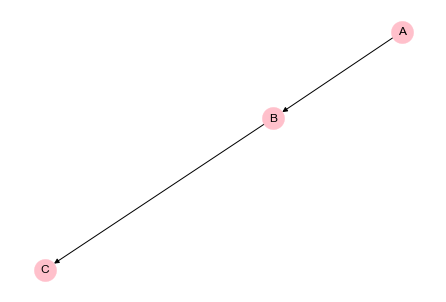

In [3]:
nx.draw(G, node_size=500, node_color='pink', with_labels=True)

In [4]:
G.edges

OutEdgeView([('A', 'B'), ('B', 'C')])

In [5]:
G.edges(data= True) #list of all edges with attributes

OutEdgeDataView([('A', 'B', {'weight': 6}), ('B', 'C', {'weight': 13})])

In [6]:
G.nodes()

NodeView(('A', 'B', 'C'))

In [7]:
G.nodes(data= True)

NodeDataView({'A': {'role': 'trader'}, 'B': {}, 'C': {}})

In [8]:
G.nodes['A']

{'role': 'trader'}

In [9]:
G.edges[('A', 'B')]

{'weight': 6}

![](simple_network.JPG)

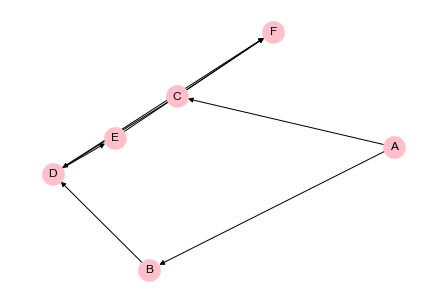

In [10]:
G=nx.DiGraph()
G.add_node('A', role = 'source')
G.add_node('F', role = 'target')

G.add_edge('A','B', weight = 1 ) # Directed edge From A to B
G.add_edge('A','C', weight = 7)
G.add_edge('B','D', weight = 2)
G.add_edge('C','D', weight = 8)
G.add_edge('D','E', weight = 9)
G.add_edge('C','F', weight = 15)
G.add_edge('D','F', weight = 1)
G.add_edge('E','F', weight = 3)

nx.draw(G, node_size=500, 
        node_color='pink', 
        with_labels=True)

In [11]:
nx.shortest_path(G,'A', 'F')

['A', 'C', 'F']

In [12]:
nx.shortest_path(G,'A', 'F', 'weight')

['A', 'B', 'D', 'F']

In [13]:
sp = nx.shortest_path(G,'A', 'F', 'weight')
list(zip(sp[:-1],sp[1:]))

[('A', 'B'), ('B', 'D'), ('D', 'F')]

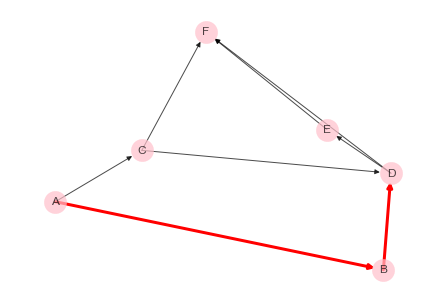

In [14]:
pos_fr = nx.fruchterman_reingold_layout(G)
pos_fr

nx.draw(G, pos=pos_fr, node_size=500, 
        alpha = 0.7, node_color='pink', 
        with_labels=True)

# Plot edges 
nx.draw_networkx_edges(G, pos=pos_fr, edgelist=[('A', 'B'), ('B', 'D')], width=3, edge_color='red')

In [15]:
labels = nx.get_edge_attributes(G,'weight')
labels

{('A', 'B'): 1,
 ('A', 'C'): 7,
 ('B', 'D'): 2,
 ('C', 'D'): 8,
 ('C', 'F'): 15,
 ('D', 'E'): 9,
 ('D', 'F'): 1,
 ('E', 'F'): 3}

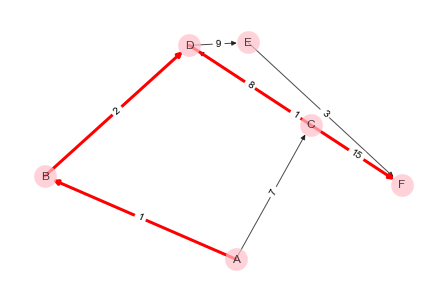

In [16]:
pos_fr = nx.fruchterman_reingold_layout(G)
pos_fr

nx.draw(G, pos=pos_fr, node_size=500, 
        alpha = 0.7, node_color='pink', 
        with_labels=True)

# Plot edges 
nx.draw_networkx_edges(G, pos=pos_fr, edgelist=list(zip(sp[:-1],sp[1:])), width=3, edge_color='red')

# Plot edge labels
nx.draw_networkx_edge_labels(G, pos=pos_fr, edge_labels=nx.get_edge_attributes(G,'weight'))
plt.tight_layout()

In [17]:
pos_fr = nx.fruchterman_reingold_layout(G)
pos_fr

{'A': array([-0.3002097 ,  0.45179994]),
 'B': array([0.15744571, 0.87212921]),
 'C': array([-0.17628822,  0.04683025]),
 'D': array([ 0.13260449, -0.18259566]),
 'E': array([ 0.35451272, -0.18816374]),
 'F': array([-0.168065, -1.      ])}

# Ant Colony

In [18]:
class ant():
    def __init__(self, env, phe, 
                 start = 'A', end = 'E',
                alpha = 1, beta = 1):
        
        self.env, self.phe  = env, phe
        
        self.alpha, self.beta = alpha, beta
        self.cities = list(self.env.columns)
        self.current_city = start
        self.target_city = end
        
        self.route = [self.current_city]
        
        self.possible_cities = self.cities.copy()
        self.possible_cities.remove(self.current_city)
    
    def move(self):
        """
        Move one step
        """
        if self.current_city == self.target_city:
            return
        
        # non-zero distances
        self.possible_cities = self.env.loc[self.current_city] != 0
        
        distances = self.env.loc[self.current_city][self.possible_cities]
        pheremons = self.phe.loc[self.current_city][self.possible_cities]
        
        preferences = pheremons**self.alpha/distances**self.beta
        probabilities = preferences/preferences.sum()
        #print(probabilities)
        
        self.current_city = np.random.choice(a = probabilities.index, 
                                             size=1, 
                                             p = probabilities.values)[0]
        
        self.route.append(self.current_city) 
        #self.possible_cities.remove(self.current_city)
        
    def go(self):
        """
        Bulid route/path
        """
        for i in range(len(self.cities)):
            self.move()

    def deposit(self):
        return self.route
        
    def cost(self):
        result = 0
        for i in range(len(self.route)-1):
            result += self.env.loc[self.route[i], self.route[i+1]]
        return result

In [19]:
class antcolony():
    def __init__(self, G):
        
        self.cities = G.nodes()
        self.true_path = nx.shortest_path(G,'A', 'F', 'weight')
        self.start, self.end = self.true_path[0], self.true_path[-1]
        
        self.env, self.phe = create_environment(G)
        
        self.true_path_ratio = []

    def evaporation(self, decay = 0.05):
        # Evaporation of Pheromon
        self.phe = self.phe * (1 - decay)
        
    def deposit(self, route, delta = 1):
        for i,j in zip(route[:-1], route[1:]):
            self.phe.loc[i, j] +=  delta/self.env.loc[i, j]
        
    def run(self, K = 10, time = 20):
        # in each time step
        for t in range(time):
            # K ants exist in the colony
            self.colony = [ant(env = self.env, phe = self.phe, 
                          start= self.start,end =  self.end) 
                      for k in range(K)]

            # distributed and paralel moves of K ants
            for k in range(K):
                self.colony[k].go()   

            # after independent moves, ants deposit pheremon
            for k in range(K):
                path = self.colony[k].deposit()
                self.deposit(route = path)
                
            self.evaporation()
            
            self.true_path_ratio.append(np.mean([a.route == self.true_path for a in self.colony]))

In [20]:
data = nx.to_numpy_matrix(G)
data

matrix([[ 0.,  0.,  1.,  7.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  2.,  0.],
        [ 0., 15.,  0.,  0.,  8.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  9.],
        [ 0.,  3.,  0.,  0.,  0.,  0.]])

In [21]:
cities = G.nodes()
cities

NodeView(('A', 'F', 'B', 'C', 'D', 'E'))

In [22]:
import pandas as pd
env = pd.DataFrame(data=data, columns=cities, index = cities)
phe = env.copy() *0.01

In [23]:
env

,A,F,B,C,D,E
A,0.0,0.0,1.0,7.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,2.0,0.0
C,0.0,15.0,0.0,0.0,8.0,0.0
D,0.0,1.0,0.0,0.0,0.0,9.0
E,0.0,3.0,0.0,0.0,0.0,0.0


In [24]:
phe

,A,F,B,C,D,E
A,0.0,0.00,0.01,0.07,0.00,0.00
F,0.0,0.00,0.00,0.00,0.00,0.00
B,0.0,0.00,0.00,0.00,0.02,0.00
C,0.0,0.15,0.00,0.00,0.08,0.00
D,0.0,0.01,0.00,0.00,0.00,0.09
E,0.0,0.03,0.00,0.00,0.00,0.00


In [25]:
def create_environment(G):
    data = nx.to_numpy_matrix(G)
    env = pd.DataFrame(data=data, columns=cities, index = cities)
    phe = env.copy() *0.01
    return env, phe
    

In [26]:
swarm = antcolony(G)
swarm.run(K = 10, time = 10)

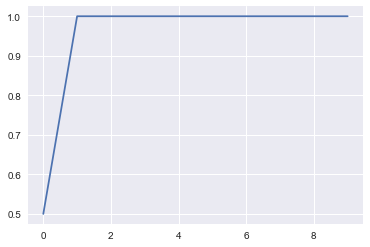

In [27]:
plt.plot(swarm.true_path_ratio)
plt.show()

In [28]:
swarm.phe

,A,F,B,C,D,E
A,0.0,0.000000,75.048495,0.212979,0.000000,0.000000
F,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
B,0.0,0.000000,0.000000,0.000000,37.533229,0.000000
C,0.0,0.129726,0.000000,0.000000,0.122741,0.000000
D,0.0,73.851021,0.000000,0.000000,0.000000,0.253465
E,0.0,0.616699,0.000000,0.000000,0.000000,0.000000


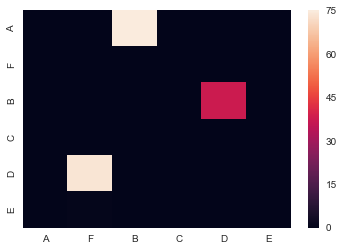

In [29]:
sns.heatmap(swarm.phe)
plt.show()

In [30]:
[a.route for a in swarm.colony]

[['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F'],
 ['A', 'B', 'D', 'F']]

In [31]:
sp = swarm.colony[0].route

In [32]:
sp

['A', 'B', 'D', 'F']

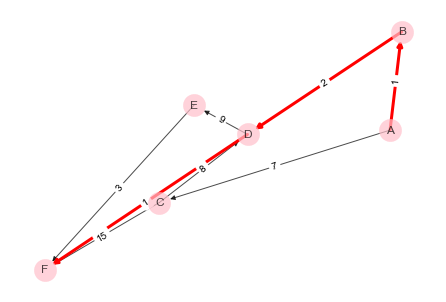

In [33]:
pos_fr = nx.fruchterman_reingold_layout(G)
pos_fr

nx.draw(G, pos=pos_fr, node_size=500, 
        alpha = 0.7, node_color='pink', 
        with_labels=True)

# Plot edges 
nx.draw_networkx_edges(G, pos=pos_fr, edgelist=list(zip(sp[:-1],sp[1:])), width=3, edge_color='red')

# Plot edge labels
nx.draw_networkx_edge_labels(G, pos=pos_fr, edge_labels=nx.get_edge_attributes(G,'weight'))
plt.tight_layout()